# Benchmark Sentence Transformers

# Introduction

In this tutorial, we will show how you can use `octoml-profile` to quickly benchmark different SentenceTransformers on various hardware software backend.

In [56]:
import pandas as pd
import os
import sys
import torch

from collections import namedtuple
from sentence_transformers import SentenceTransformer, util
from typing import List
from octoml_profile import accelerate, remote_profile, RemoteInferenceSession
from octoml_profile.report import ProfileReport

## Step 1: Set the necessary environment variables

In [57]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
#os.environ['OCTOML_PROFILE_API_TOKEN'] = "REPLACE ME"

## Step 2: Define what API we want to measure

This is the API we are interested in benchmarking. It takes a list of query strings, and a precomputed corpus embeddings, returns the topk similar document per query string, and their score.

The magic `accelerate` decorator will be used later to run and benchmark tensor programs remotely.

In [58]:
@accelerate
def semantic_search(model, queries: List[str], corpus_embeddings: List[torch.Tensor], topk: int):
    """Example from https://www.sbert.net/examples/applications/semantic-search/README.html
    """
    topk = min(topk, len(corpus))
    query_embedding = model.encode(queries, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)
    topk_scores, topk_index = torch.topk(cos_scores, k=topk, dim=-1)
    return (topk_scores, topk_index)

In [59]:
def run_model(model_id: str, queries: List[str], corpus: List[str]):
    print("======================")
    print("Model:", model_id)
    model = SentenceTransformer(model_id)
    corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
    # run two times and the initial run with compilcation will be discarded
    for _ in range(2):
        scores, indices = semantic_search(model, queries, corpus_embeddings, topk=5)
    for query_id, query in enumerate(queries):
        print("\nQuery:", query)
        print("Top 5 most similar sentences in corpus:")
        for score, doc_id in zip(scores[query_id], indices[query_id]):
            print(corpus[doc_id], "(Score: {:.4f})".format(score))
    print("======================\n\n")

In [60]:
# Test the code works locally
# TODO: onnx local backend is broken, enable eager backend
## run_model('all-MiniLM-L6-v2', ['foo'], ['foo2', 'bar2'])

## Step 3: Prepare Remote Benchmark Code

To run the same code above but on remote hardware/software backend, we simply need to wrap the `run_model` with a `RemoteInferenceSession` and `remote_profile` context manager.

In [61]:
BenchmarkRecord = namedtuple('Record', ['model', 'backend', 'time_ms', 'cost_per_mreq'])

In [62]:
def remote_benchmark(model_id, queries, corpus, backends=None, verbose=True) -> List[BenchmarkRecord]:
    session = RemoteInferenceSession(backends=backends)
    with session.as_default():
        with remote_profile(print_results_to=sys.stdout if verbose else None) as r:
            run_model(model_id, queries, corpus)
            return parse_report(model_id, r.report())

In [63]:
def parse_report(model_id, report: ProfileReport) -> List[BenchmarkRecord]:
    """Helper function to parse the profiling report
    """
    records = []
    hw_cost = {
        'r6i.large': 0.126,
        'r6g.large': 0.1008,
        'g4dn.xlarge': 0.526,
        'g5.xlarge': 1.006
    }
    assert len(report.profiles) == 1
    uncompiled_code_ms = report.profiles[0].total_uncompiled_ms
    for backend, result in report.profiles[0].total_per_backend.items():
        if len(result.errors) > 0:
            message = "\n".join(result.errors)
            raise RuntimeError(f"Error in running {model_id} on {backend}: {message}")
        total_time_ms = uncompiled_code_ms + result.estimated_total_ms
        cost_per_hr = hw_cost[backend.split("/")[0]]
        cost_per_mreq = cost_per_hr * (1e6 * total_time_ms / (3600 * 1000))
        records.append(BenchmarkRecord(model_id, backend, total_time_ms, cost_per_mreq))
    return records


### Step 4: Set the data and try remote benchmark with one model

In [64]:
queries = ['A man is eating pasta.',
           'Someone in a gorilla costume is playing a set of drums.',
           'A cheetah chases prey on across a field.']

corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'The girl is carrying a baby.',
          'A man is riding a horse.',
          'A woman is playing violin.',
          'Two men pushed carts through the woods.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'A cheetah is running behind its prey.'
          ]

In [65]:
remote_benchmark('all-MiniLM-L6-v2', queries, corpus)

No backends were requested, so requesting default backends ['r6i.large/onnxrt-cpu', 'g4dn.xlarge/onnxrt-cuda']
Model: all-MiniLM-L6-v2

Query: A man is eating pasta.
Top 5 most similar sentences in corpus:
A man is eating food. (Score: 0.7035)
A man is eating a piece of bread. (Score: 0.5272)
A man is riding a horse. (Score: 0.1889)
A man is riding a white horse on an enclosed ground. (Score: 0.1047)
A cheetah is running behind its prey. (Score: 0.0980)

Query: Someone in a gorilla costume is playing a set of drums.
Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.6433)
A woman is playing violin. (Score: 0.2564)
A man is riding a horse. (Score: 0.1389)
A man is riding a white horse on an enclosed ground. (Score: 0.1191)
A cheetah is running behind its prey. (Score: 0.1080)

Query: A cheetah chases prey on across a field.
Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.8253)
A man is eating food. (Score: 0.1399)
A monke

[Record(model='all-MiniLM-L6-v2', backend='r6i.large/onnxrt-cpu', time_ms=12.0683761, cost_per_mreq=0.4223931635),
 Record(model='all-MiniLM-L6-v2', backend='g4dn.xlarge/onnxrt-cuda', time_ms=4.9610061000000005, cost_per_mreq=0.7248581135000001)]

### Step 5: Let's evaluate on many models and many backends

In [66]:
# Models can be found from: https://www.sbert.net/docs/pretrained_models.html
model_ids = ['all-MiniLM-L12-v2',
             'all-MiniLM-L6-v2',
             'all-distilroberta-v1',
             'paraphrase-albert-small-v2',
             'paraphrase-MiniLM-L3-v2',
             ]
# Backends can be found from `session.supported_backends()`
backends = ['r6i.large/onnxrt-cpu',
            'r6g.large/onnxrt-cpu',
            'g4dn.xlarge/onnxrt-cuda',
            'g4dn.xlarge/onnxrt-tensorrt'
            ]

In [67]:
def benchmark_all(model_ids, backends, output_file):
    records = []
    for model_id in model_ids:
        results = remote_benchmark(model_id,
                                   queries,
                                   corpus,
                                   backends=backends,
                                   verbose=False)
        records.extend(results)
    df = pd.DataFrame(data=records)
    df.to_csv(output_file)
    return df

In [74]:
result_file = 'sentence_transformer_eval.csv'
if not os.path.exists(result_file):
    benchmark_all(model_ids, backends, result_file)

## Step 6: Analyze the result

In [75]:
df = pd.read_csv(result_file, index_col=0)
with pd.option_context('display.width', 120):
    print (df)

                         model                      backend     time_ms  cost_per_mreq
0            all-MiniLM-L12-v2         r6i.large/onnxrt-cpu   26.449554       0.925734
1            all-MiniLM-L12-v2         r6g.large/onnxrt-cpu   64.699734       1.811593
2            all-MiniLM-L12-v2      g4dn.xlarge/onnxrt-cuda    9.791207       1.430604
3            all-MiniLM-L12-v2  g4dn.xlarge/onnxrt-tensorrt   12.364989       1.806662
4             all-MiniLM-L6-v2         r6i.large/onnxrt-cpu   13.961583       0.488655
5             all-MiniLM-L6-v2         r6g.large/onnxrt-cpu   33.893506       0.949018
6             all-MiniLM-L6-v2      g4dn.xlarge/onnxrt-cuda    6.681914       0.976302
7             all-MiniLM-L6-v2  g4dn.xlarge/onnxrt-tensorrt    7.773372       1.135776
8         all-distilroberta-v1         r6i.large/onnxrt-cpu   39.487310       1.382056
9         all-distilroberta-v1         r6g.large/onnxrt-cpu  113.382527       3.174711
10        all-distilroberta-v1      g4dn.xl

In [76]:
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

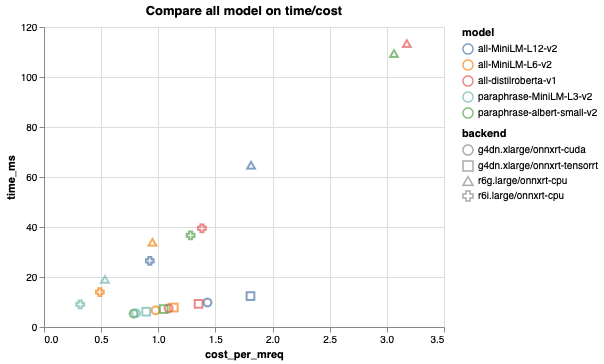

In [80]:
alt.Chart(df).mark_point(size=60).encode(
    x='cost_per_mreq',
    y='time_ms',
    color='model',
    shape='backend',
).properties(title='Compare all model on time/cost')

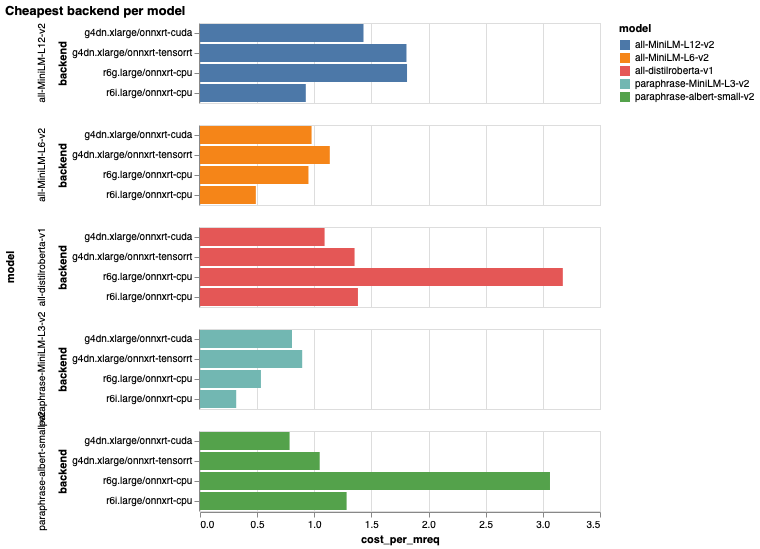

In [81]:
alt.Chart(df).mark_bar().encode(
    y='backend',
    x='cost_per_mreq',
    color='model',
    row='model'
).properties(title='Cheapest backend per model')

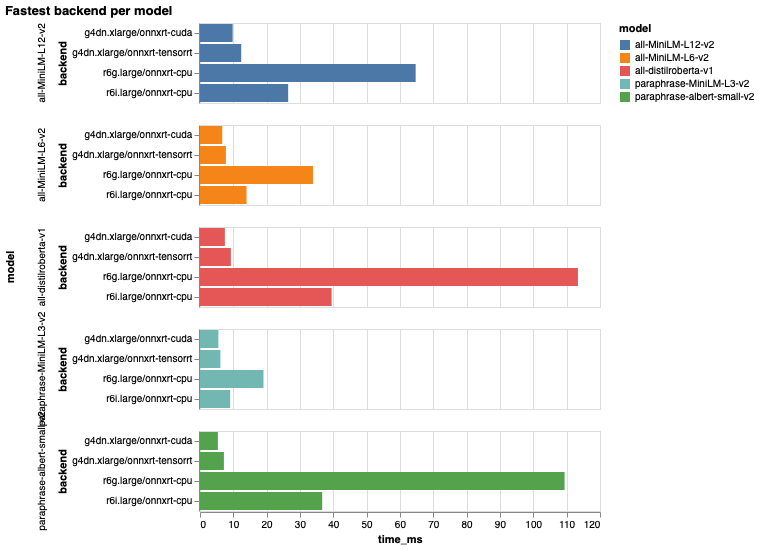

In [82]:
alt.Chart(df).mark_bar().encode(
    y='backend',
    x='time_ms',
    color='model',
    row='model',
).properties(title='Fastest backend per model')